### Import

In [2]:
import cv2
# import torch
import numpy as np
# from art import tprint
from torchvision.transforms.functional import to_pil_image

In [3]:
classes = [
'person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa',
'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard',
'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
'teddy bear', 'hair drier', 'toothbrush'
]

### Image detection

In [4]:
def draw_object_bounding_box(image_to_process, index, box):
    """
    Drawing object borders with captions
    :param image_to_process: original image
    :param index: index of object class defined with YOLO
    :param box: coordinates of the area around the object
    :return: image with marked objects
    """

    x, y, w, h = box
    start = (x, y)
    end = (x + w, y + h)
    color = (0, 255, 0)
    width = 2
    final_image = cv2.rectangle(image_to_process, start, end, color, width)

    start = (x, y - 10)
    font_size = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    width = 2
    text = classes[index]
    final_image = cv2.putText(final_image, text, start, font,
                              font_size, color, width, cv2.LINE_AA)

    return final_image

In [5]:
def draw_object_count(image_to_process, objects_count):
    """
    Signature of the number of found objects in the image
    :param image_to_process: original image
    :param objects_count: the number of objects of the desired class
    :return: image with labeled number of found objects
    """

    start = (10, 120)
    font_size = 1.5
    font = cv2.FONT_HERSHEY_SIMPLEX
    width = 3
    text = "Objects found: " + str(objects_count)

    # Text output with a stroke
    # (so that it can be seen in different lighting conditions of the picture)
    white_color = (255, 255, 255)
    black_outline_color = (0, 0, 0)
    final_image = cv2.putText(image_to_process, text, start, font, font_size,
                              black_outline_color, width * 3, cv2.LINE_AA)
    final_image = cv2.putText(final_image, text, start, font, font_size,
                              white_color, width, cv2.LINE_AA)

    return final_image

In [6]:

def apply_yolo_object_detection(model, image_to_process, show_classes=None):
    """
    Recognition and determination of the coordinates of objects on the image
    :param image_to_process: original image
    :return: image with marked objects and captions to them
    """
    layer_names = model.getLayerNames()
    out_layers_indexes = model.getUnconnectedOutLayers()
    out_layers = [layer_names[index - 1] for index in out_layers_indexes]

    height, width, _ = image_to_process.shape
    blob = cv2.dnn.blobFromImage(image_to_process, 1 / 255, (608, 608),
                                 (0, 0, 0), swapRB=True, crop=False)
    model.setInput(blob)
    outs = model.forward(out_layers)
    class_indexes, class_scores, boxes = ([] for i in range(3))
    objects_count = 0

    # Starting a search for objects in an image
    for out in outs:
        for obj in out:
            scores = obj[5:]
            class_index = np.argmax(scores)
            class_score = scores[class_index]
            if class_score > 0:
                center_x = int(obj[0] * width)
                center_y = int(obj[1] * height)
                obj_width = int(obj[2] * width)
                obj_height = int(obj[3] * height)
                box = [center_x - obj_width // 2, center_y - obj_height // 2,
                       obj_width, obj_height]
                boxes.append(box)
                class_indexes.append(class_index)
                class_scores.append(float(class_score))

    # Selection
    chosen_boxes = cv2.dnn.NMSBoxes(boxes, class_scores, 0.0, 0.4)
    for box_index in chosen_boxes:
        box_index = box_index
        box = boxes[box_index]
        class_index = class_indexes[box_index]

        # For debugging, we draw objects included in the desired classes
        if show_classes != None and class_index in show_classes:
            objects_count += 1
            image_to_process = draw_object_bounding_box(image_to_process, class_index, box)

    final_image = draw_object_count(image_to_process, objects_count)
    return final_image

Test image capture

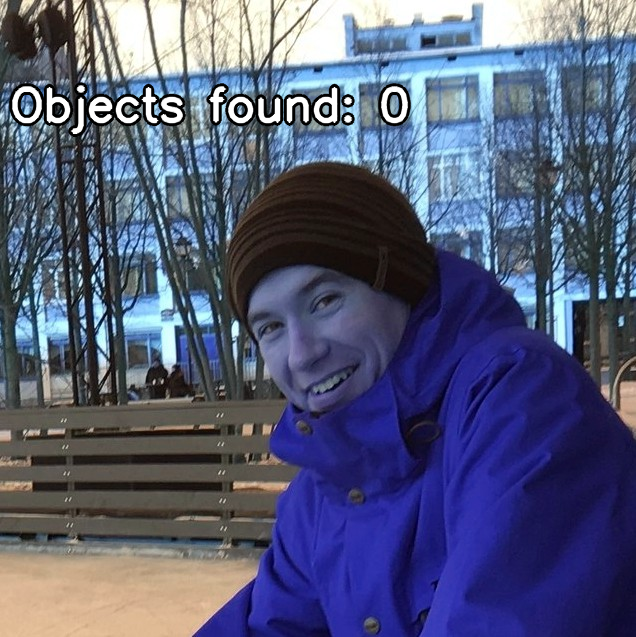

In [7]:
net = cv2.dnn.readNetFromDarknet("../models/yolov4-tiny.cfg",
                                    "../models/yolov4-tiny.weights")

image = cv2.imread('../data/images/0je5b4V4MQ0_1.jpg')
result = apply_yolo_object_detection(net, image)
to_pil_image(result)

### Video detection

In [ ]:
def start_video_object_detection(model, video: str, show_classes=None):
    """
    Real-time video capture and analysis
    """
    while True:
        try:
            # Capturing a picture from a video
            video_camera_capture = cv2.VideoCapture(video)
            
            while video_camera_capture.isOpened():
                ret, frame = video_camera_capture.read()
                if not ret:
                    break
                
                # Application of object recognition methods on a video frame from YOLO
                frame = apply_yolo_object_detection(model, frame, show_classes=None)
                
                # Displaying the processed image on the screen with a reduced window size
                frame = cv2.resize(frame, (1920 // 2, 1080 // 2))
                cv2.imshow("Video Capture", frame)
                cv2.waitKey(1)
            
            video_camera_capture.release()
            cv2.destroyAllWindows()
    
        except KeyboardInterrupt:
            pass

In [ ]:
video = input("Path to video (or URL): ")
# look_for = input("What we are looking for: ").split(',')

# Delete spaces
# list_look_for = []
# for look in look_for:
#     list_look_for.append(look.strip())

# start_video_object_detection(net, video, show_classes=list_look_for)
start_video_object_detection(net, video)